<a href="https://colab.research.google.com/github/Shim-John/ml_mpw_modeling/blob/master/LSTM/LSTM_20_Tracks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1JFULutBLUSm0cXh5veNU5hWjwKRqaODi'})   # replace the id with id of file you want to access
downloaded.GetContentFile('DNN_20.csv') 


In [2]:
import torch, pandas as pd
import torch.nn as nn 
import torch.nn.functional as F 
import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable
import torch.utils.data as Data
import numpy as np, imageio
from sklearn.preprocessing import MinMaxScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(1)    # reproducible


In [3]:
x = pd.read_csv('DNN_20.csv')

x = x.values    #x is numpy

X_modified = []
Y_modified = []

t_modified = x[93:,0]


X_modified = x[93:,1]
Y_modified = x[94:,1]

train_size = 1500
test_size = len(X_modified)-train_size


trainX, testX = np.array(X_modified[0:train_size]), np.array(X_modified[train_size:])
trainY, testY = np.array(Y_modified[0:train_size]), np.array(Y_modified[train_size:])


trainX = np.reshape(trainX, (-1, 1))
trainY = np.reshape(trainY, (-1, 1))
testX = np.reshape(testX, (-1, 1))
testY = np.reshape(testY, (-1, 1))


In [4]:
scaler = MinMaxScaler(feature_range=(-1, 1))
trainX = scaler.fit_transform(trainX .reshape(-1, 1))
testX = scaler.fit_transform(testX .reshape(-1, 1))
trainY = scaler.fit_transform(trainY .reshape(-1, 1))




trainX = torch.from_numpy(np.array(trainX)).type(torch.float32)
testX = torch.from_numpy(np.array(testX)).type(torch.float32)
trainY = torch.from_numpy(np.array(trainY)).type(torch.float32)
testY = torch.from_numpy(np.array(testY)).type(torch.float32)



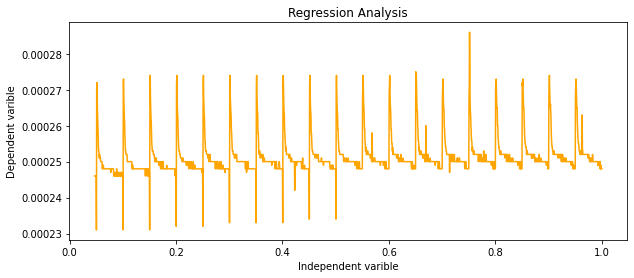

In [5]:
# view data
plt.figure(figsize=(10,4))
plt.plot(t_modified, X_modified, color = "orange")
#plt.scatter(X.data.numpy(), Y.data.numpy(), color = "orange")
plt.title('Regression Analysis')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.show()

In [6]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

In [7]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)  
trainX = trainX.to(device)

In [8]:
train_window = 200
train_inout_seq = create_inout_sequences(trainX, train_window)


In [9]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size).to(device),
                            torch.zeros(1,1,self.hidden_layer_size).to(device))
        

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)


        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [10]:
model = LSTM()
model.to(device)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.06)

In [11]:
epochs = 70
model.train()
for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))
        
        
        y_pred = model(seq)
        

        single_loss = loss_function(y_pred, labels[-1])
        single_loss.backward()
        optimizer.step()
        

    if i%5 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00017612
epoch:   6 loss: 0.03250322
epoch:  11 loss: 0.01359272
epoch:  16 loss: 0.03407234
epoch:  21 loss: 0.80223167
epoch:  26 loss: 0.01148527
epoch:  31 loss: 0.09312528
epoch:  36 loss: 0.05907231
epoch:  41 loss: 0.76143193
epoch:  46 loss: 0.00057107
epoch:  51 loss: 0.10948561
epoch:  56 loss: 0.04591669
epoch:  61 loss: 0.00758618
epoch:  66 loss: 0.04900137
epoch:  69 loss: 0.0075062523


In [12]:
device = torch.device('cpu')  
model.to(device)

LSTM(
  (lstm): LSTM(1, 100)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)

In [13]:
model.hidden_cell = list(model.hidden_cell)
model.hidden_cell[0] = model.hidden_cell[0].to('cpu')
model.hidden_cell[1] = model.hidden_cell[1].to('cpu')
model.hidden_cell = tuple(model.hidden_cell)

In [14]:
model.eval()

train_inputs = trainX[0:train_size].view(-1).cpu()
train_inputs = train_inputs.detach().numpy().tolist()


for i in range(train_size):
    seq = torch.FloatTensor(train_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to('cpu'),
                        torch.zeros(1, 1, model.hidden_layer_size).to('cpu'))
        
        train_inputs.append(model(seq).item())
        


In [15]:
train_result = scaler.inverse_transform(np.array(train_inputs).reshape(-1, 1))



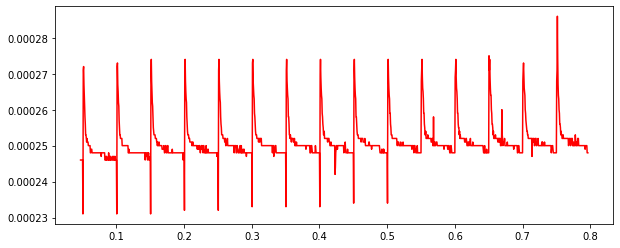

In [34]:
plt.figure(figsize=(10,4))

#plt.xlim(0, 0.15)
#plt.ylim(0.0002,0.0003)
plt.plot(t_modified[0:train_size], train_result[0:train_size], color = "red")
#plt.plot(t_modified, X_modified, color = "orange")
#plt.xlim(0.4, 0.5)
#plt.title('Regression Analysis')
#plt.xlabel('Independent varible')
#plt.ylabel('Dependent varible')
plt.show()


In [19]:
fut_pred = test_size

test_inputs = trainX[-test_size:].view(-1).cpu()
test_inputs = test_inputs.detach().numpy().tolist()


In [20]:
#Test Predction

model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-train_window:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

In [21]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs).reshape(-1, 1))

In [ ]:
print

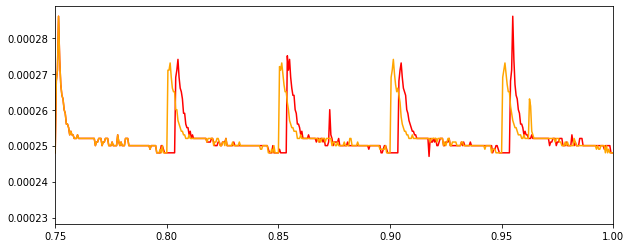

In [40]:
plt.figure(figsize=(10,4))

#plt.plot(actual_predictions)
plt.plot(t_modified[0:train_size], train_result[0:train_size], color = "red")
plt.plot(t_modified[-test_size:], actual_predictions[:test_size], color = "red")
plt.plot(t_modified, X_modified, color = "orange")
#plt.xlim(0, 0.3)
plt.xlim(0.75, 1)
#plt.title('Regression Analysis')
#plt.xlabel('Independent varible')
#plt.ylabel('Dependent varible')
plt.show()


